<a href="https://colab.research.google.com/github/santoshrsarangi/tensorflow/blob/main/new/Pitch_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt-get install -q -y timidity libsndfile1

Reading package lists...
Building dependency tree...
Reading state information...
libsndfile1 is already the newest version (1.0.28-7ubuntu0.1).
The following additional packages will be installed:
  fluid-soundfont-gm libao-common libao4
Suggested packages:
  fluid-soundfont-gs fluidsynth libaudio2 libsndio6.1 freepats pmidi
  timidity-daemon
The following NEW packages will be installed:
  fluid-soundfont-gm libao-common libao4 timidity
0 upgraded, 4 newly installed, 0 to remove and 15 not upgraded.
Need to get 120 MB of archives.
After this operation, 150 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu focal/main amd64 libao-common all 1.2.2+20180113-1ubuntu1 [6,644 B]
Get:3 http://archive.ubuntu.com/ubuntu focal/main amd64 libao4 amd64 1.2.2+20180113-1ubuntu1 [35.1 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/universe amd64 timidity amd64 2.14.0-8b

In [2]:
!pip install pydub librosa music21

In [3]:
import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import librosa
from librosa import display as librosadisplay

import logging
import math
import statistics
import sys

from IPython.display import Audio, Javascript
from scipy.io import wavfile

from base64 import b64decode

import music21
from pydub import AudioSegment

logger = logging.getLogger()
logger.setLevel(logging.ERROR)

print("tensorflow: %s" % tf.__version__)
print("librosa: %s" % librosa.__version__)

tensorflow: 2.12.0
librosa: 0.10.0.post2


In [5]:
RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=5):
  try:
    from google.colab import output
  except ImportError:
    print('No possible to import output from google.colab')
    return ''
  else:
    print('Recording')
    display(Javascript(RECORD))
    s = output.eval_js('record(%d)' % (sec*1000))
    fname = 'recorded_audio.wav'
    print('Saving to', fname)
    b = b64decode(s.split(',')[1])
    with open(fname, 'wb') as f:
      f.write(b)
    return fname

In [7]:
record()

Recording


<IPython.core.display.Javascript object>

Saving to recorded_audio.wav


'recorded_audio.wav'

In [8]:
# Function that converts the user-created audio to the format that the model
# expects: bitrate 16kHz and only one channel (mono).

EXPECTED_SAMPLE_RATE = 16000

def convert_audio_for_model(user_file, output_file='converted_audio_file.wav'):
  audio = AudioSegment.from_file(user_file)
  audio = audio.set_frame_rate(EXPECTED_SAMPLE_RATE).set_channels(1)
  audio.export(output_file, format="wav")
  return output_file

In [9]:
uploaded_file_name = "recorded_audio.wav"

In [10]:
# Converting to the expected format for the model
# in all the input 4 input method before, the uploaded file name is at
# the variable uploaded_file_name
converted_audio_file = convert_audio_for_model(uploaded_file_name)

In [11]:
# Loading audio samples from the wav file:
sample_rate, audio_samples = wavfile.read(converted_audio_file, 'rb')

# Show some basic information about the audio.
duration = len(audio_samples)/sample_rate
print(f'Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(audio_samples)}')

# Let's listen to the wav file.
Audio(audio_samples, rate=sample_rate)

Sample rate: 16000 Hz
Total duration: 1.00s
Size of the input: 15975


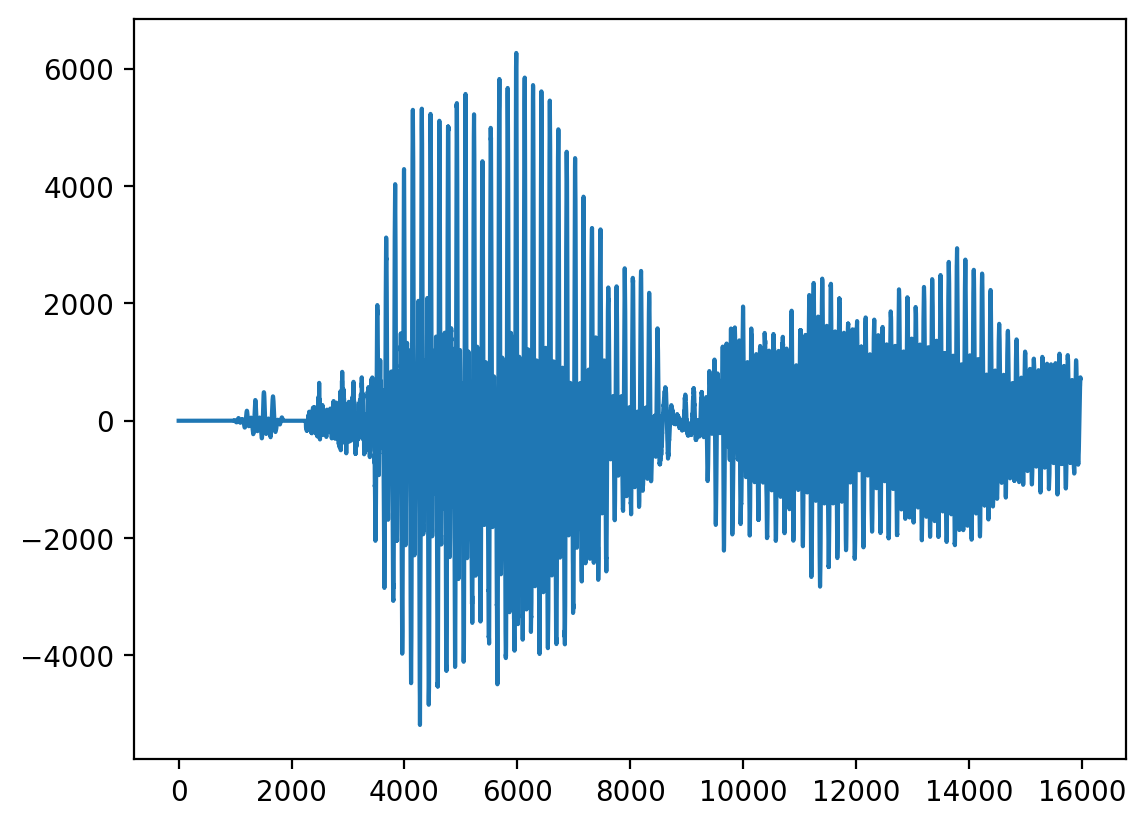

In [12]:
# We can visualize the audio as a waveform.
_ = plt.plot(audio_samples)

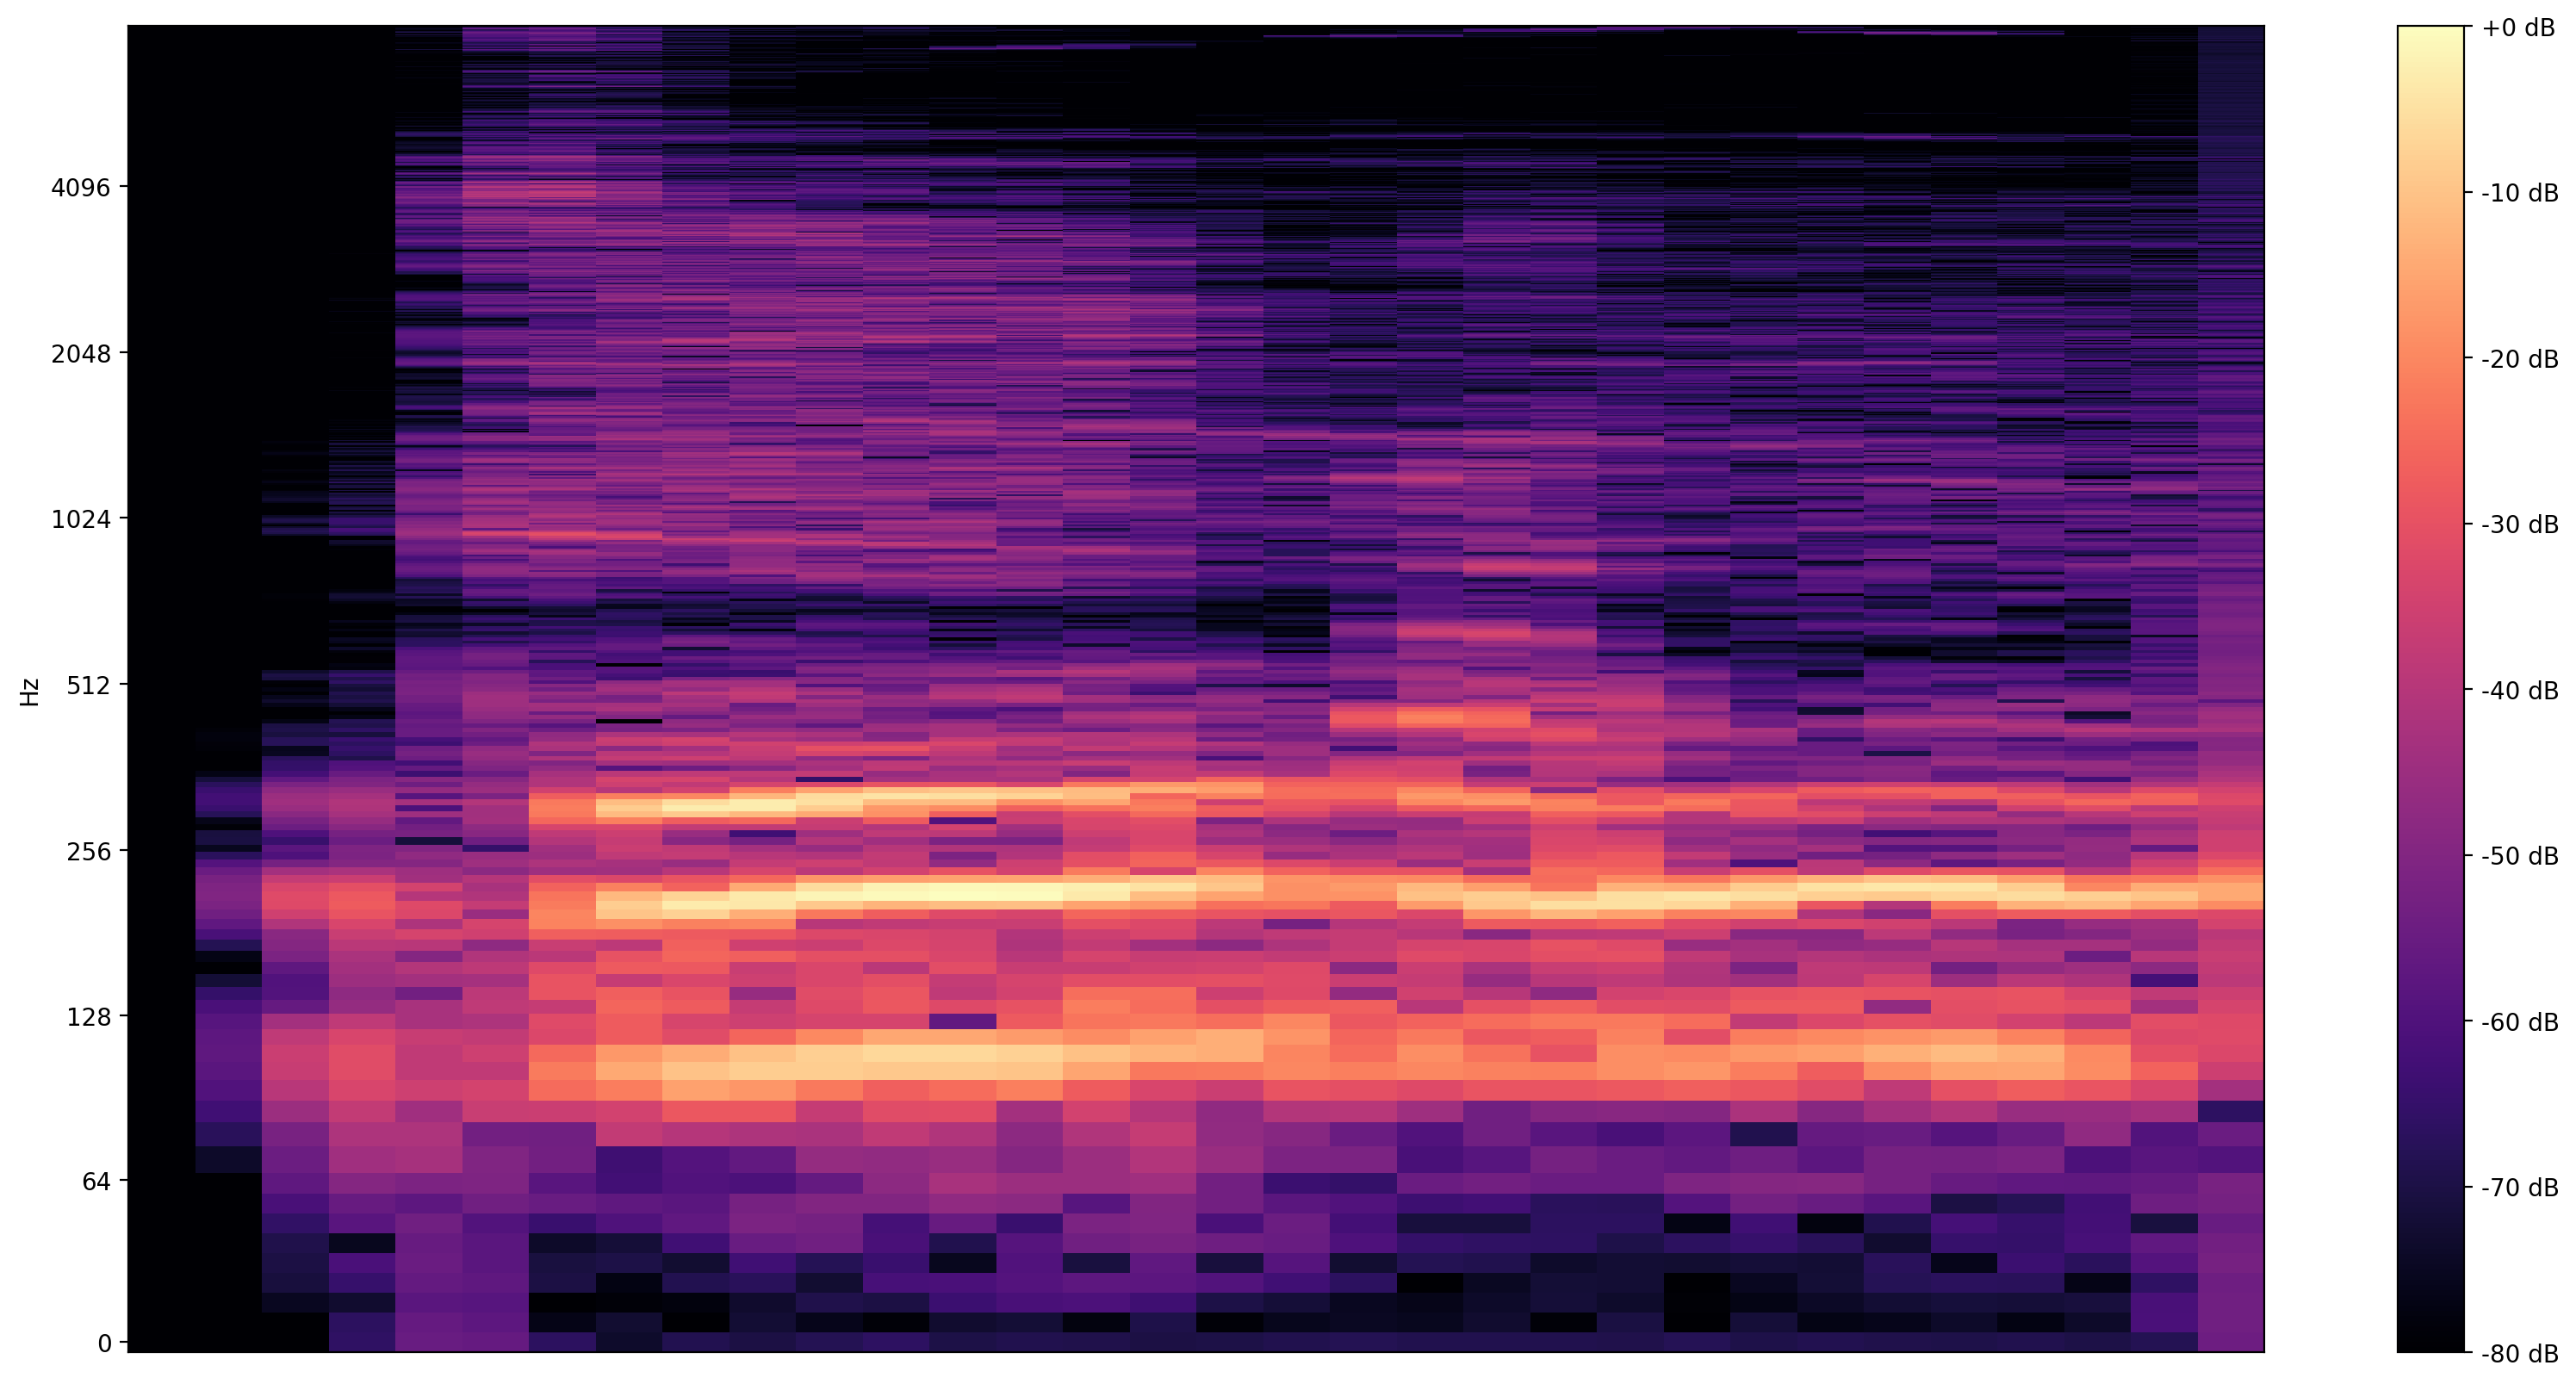

In [13]:
MAX_ABS_INT16 = 32768.0

def plot_stft(x, sample_rate, show_black_and_white=False):
  x_stft = np.abs(librosa.stft(x, n_fft=2048))
  fig, ax = plt.subplots()
  fig.set_size_inches(20, 10)
  x_stft_db = librosa.amplitude_to_db(x_stft, ref=np.max)
  if(show_black_and_white):
    librosadisplay.specshow(data=x_stft_db, y_axis='log',
                             sr=sample_rate, cmap='gray_r')
  else:
    librosadisplay.specshow(data=x_stft_db, y_axis='log', sr=sample_rate)

  plt.colorbar(format='%+2.0f dB')

plot_stft(audio_samples / MAX_ABS_INT16 , sample_rate=EXPECTED_SAMPLE_RATE)
plt.show()

In [14]:
audio_samples = audio_samples / float(MAX_ABS_INT16)

In [15]:
# Loading the SPICE model is easy:
model = hub.load("https://tfhub.dev/google/spice/2")

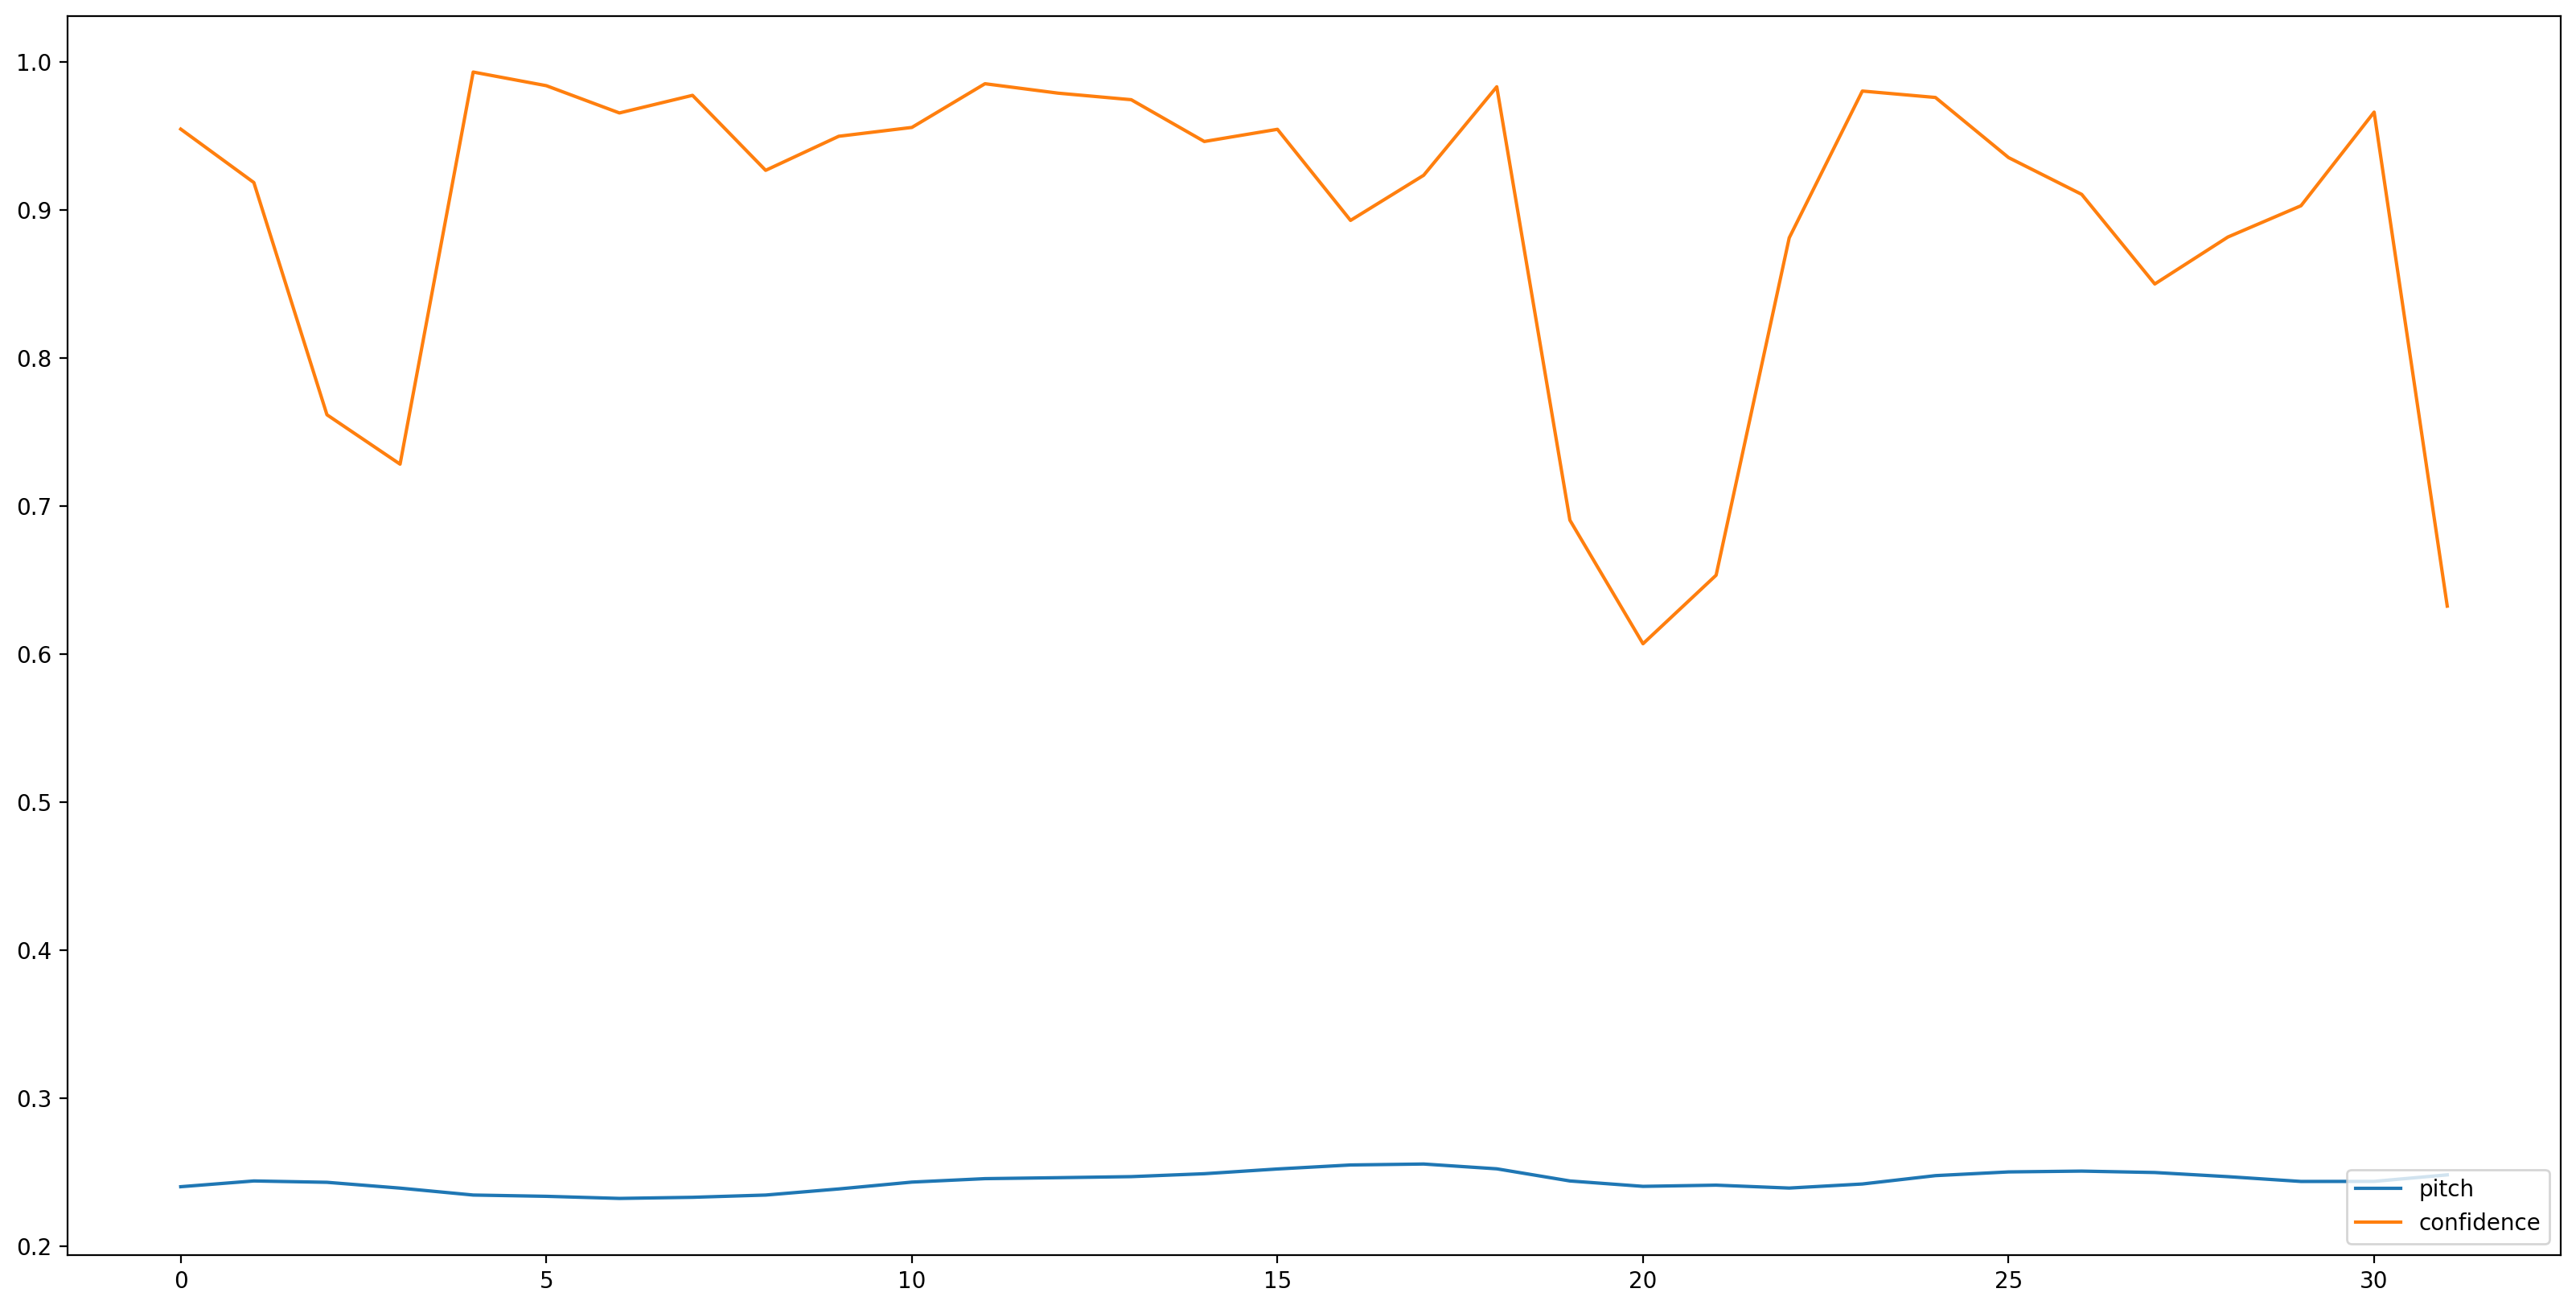

In [16]:
# We now feed the audio to the SPICE tf.hub model to obtain pitch and uncertainty outputs as tensors.
model_output = model.signatures["serving_default"](tf.constant(audio_samples, tf.float32))

pitch_outputs = model_output["pitch"]
uncertainty_outputs = model_output["uncertainty"]

# 'Uncertainty' basically means the inverse of confidence.
confidence_outputs = 1.0 - uncertainty_outputs

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
plt.plot(pitch_outputs, label='pitch')
plt.plot(confidence_outputs, label='confidence')
plt.legend(loc="lower right")
plt.show()

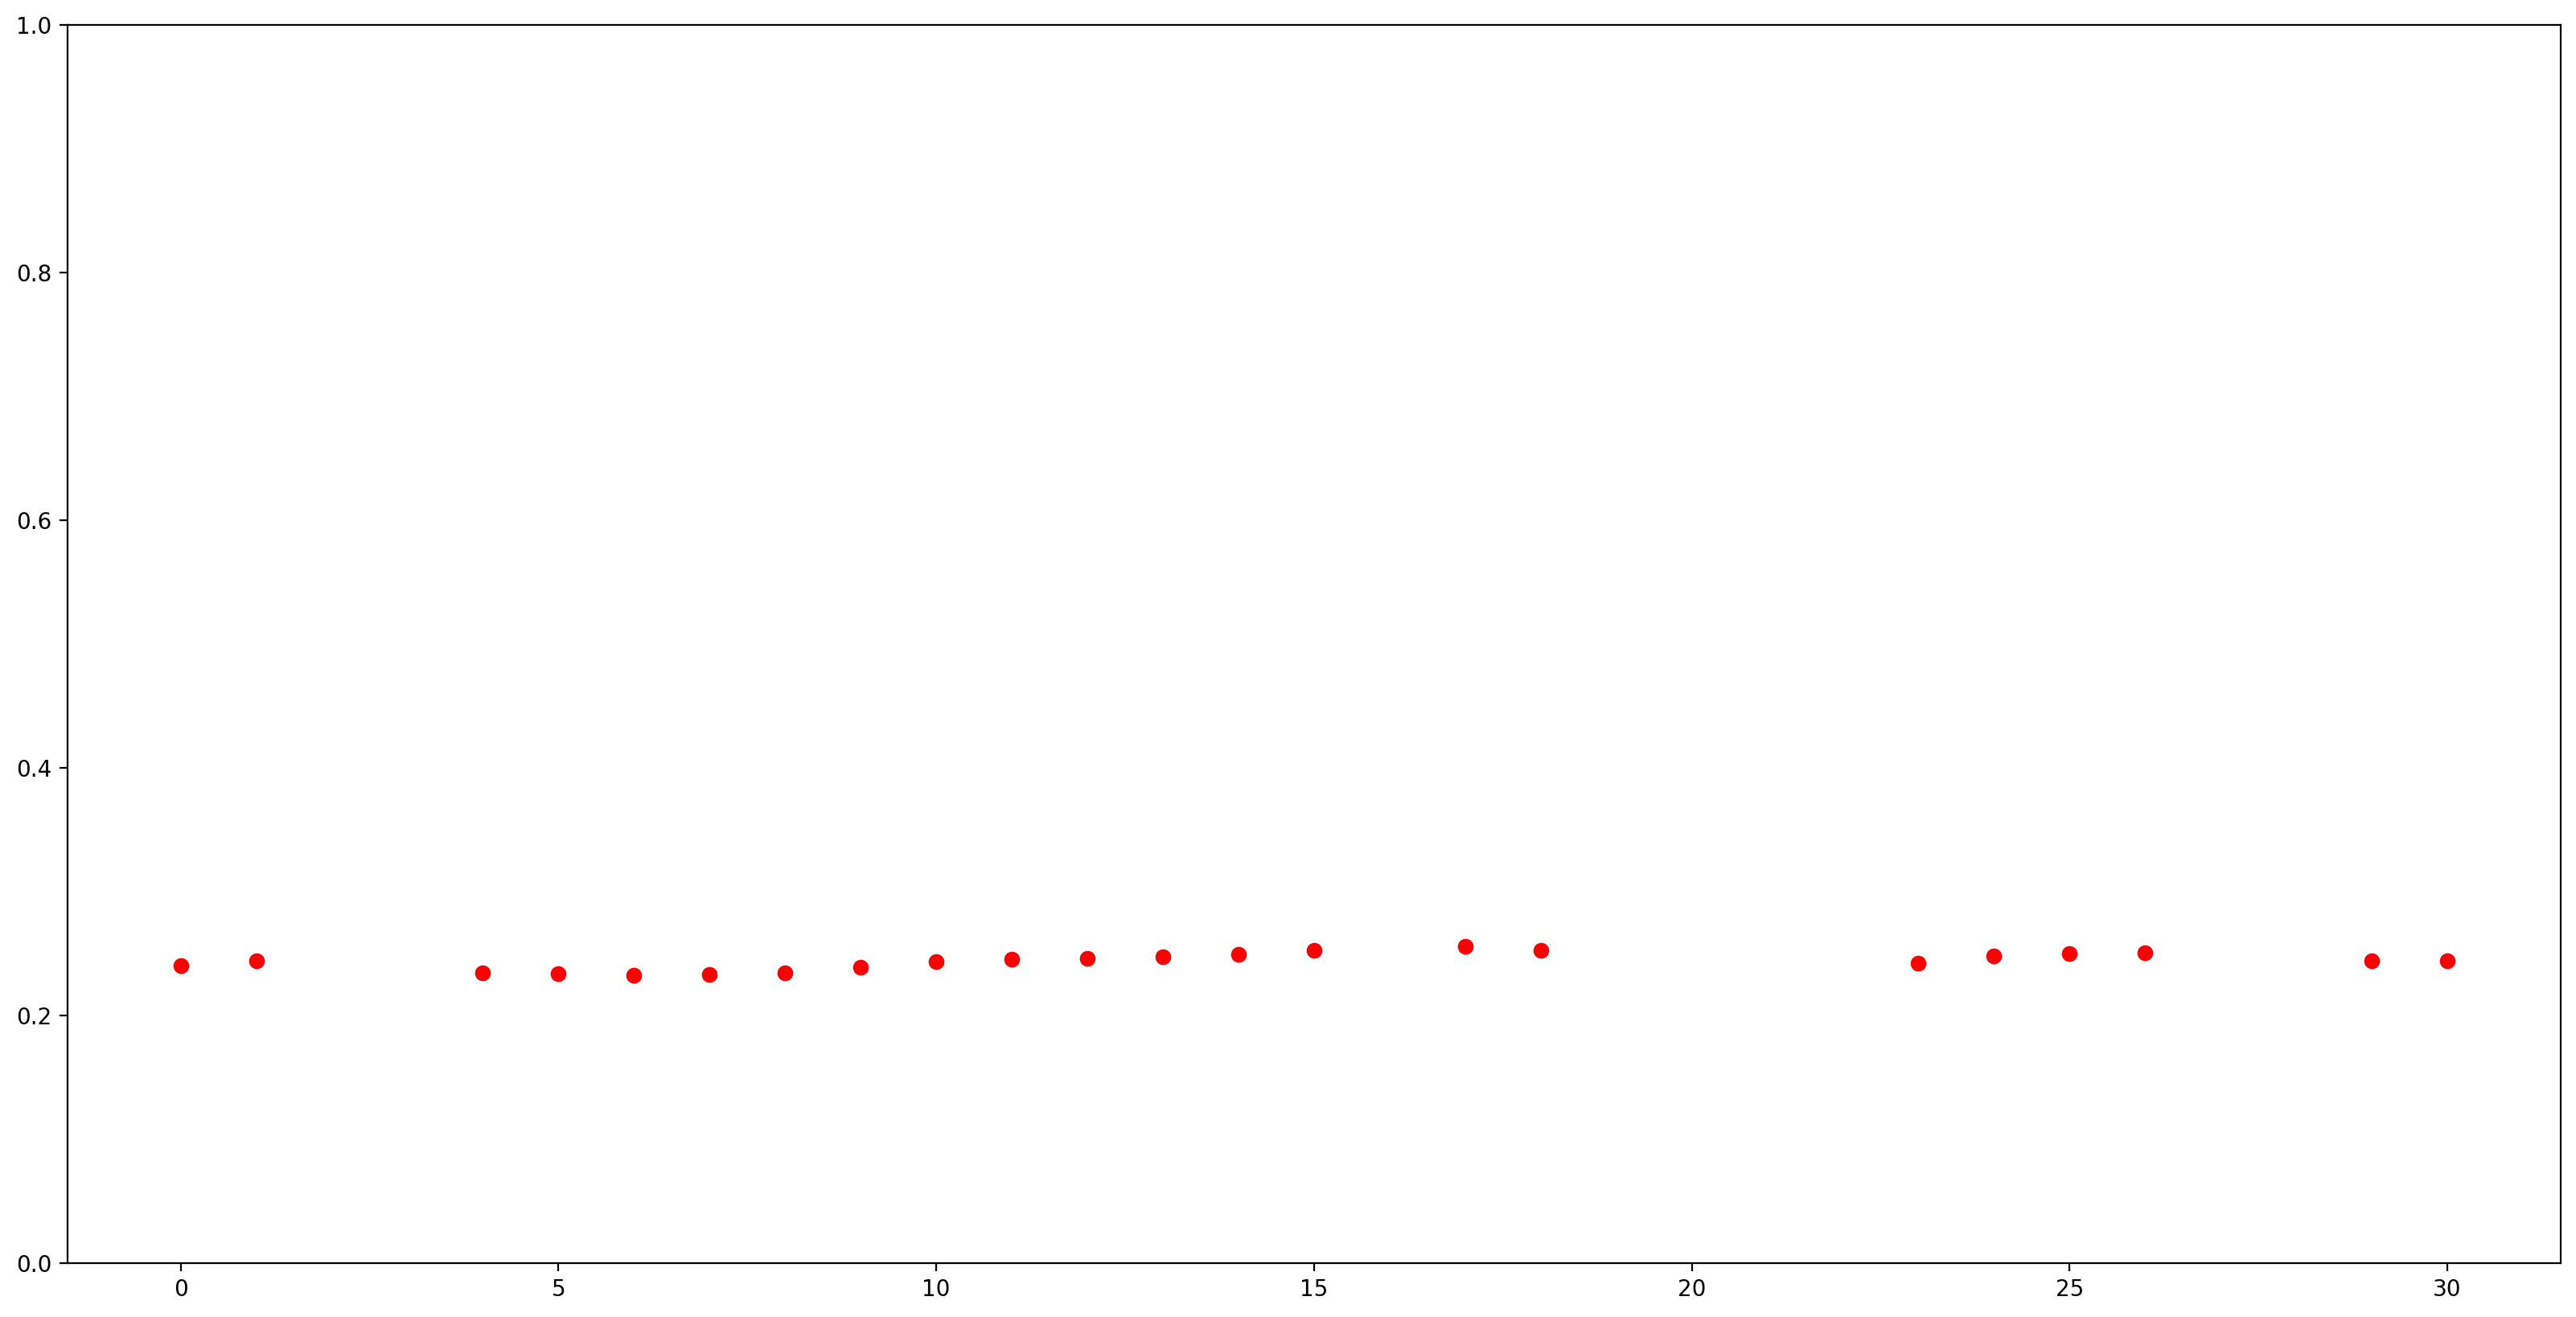

In [17]:
confidence_outputs = list(confidence_outputs)
pitch_outputs = [ float(x) for x in pitch_outputs]

indices = range(len (pitch_outputs))
confident_pitch_outputs = [ (i,p)
  for i, p, c in zip(indices, pitch_outputs, confidence_outputs) if  c >= 0.9  ]
confident_pitch_outputs_x, confident_pitch_outputs_y = zip(*confident_pitch_outputs)

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
ax.set_ylim([0, 1])
plt.scatter(confident_pitch_outputs_x, confident_pitch_outputs_y, )
plt.scatter(confident_pitch_outputs_x, confident_pitch_outputs_y, c="r")

plt.show()

In [18]:
def output2hz(pitch_output):
  # Constants taken from https://tfhub.dev/google/spice/2
  PT_OFFSET = 25.58
  PT_SLOPE = 63.07
  FMIN = 10.0;
  BINS_PER_OCTAVE = 12.0;
  cqt_bin = pitch_output * PT_SLOPE + PT_OFFSET;
  return FMIN * 2.0 ** (1.0 * cqt_bin / BINS_PER_OCTAVE)

confident_pitch_values_hz = [ output2hz(p) for p in confident_pitch_outputs_y ]

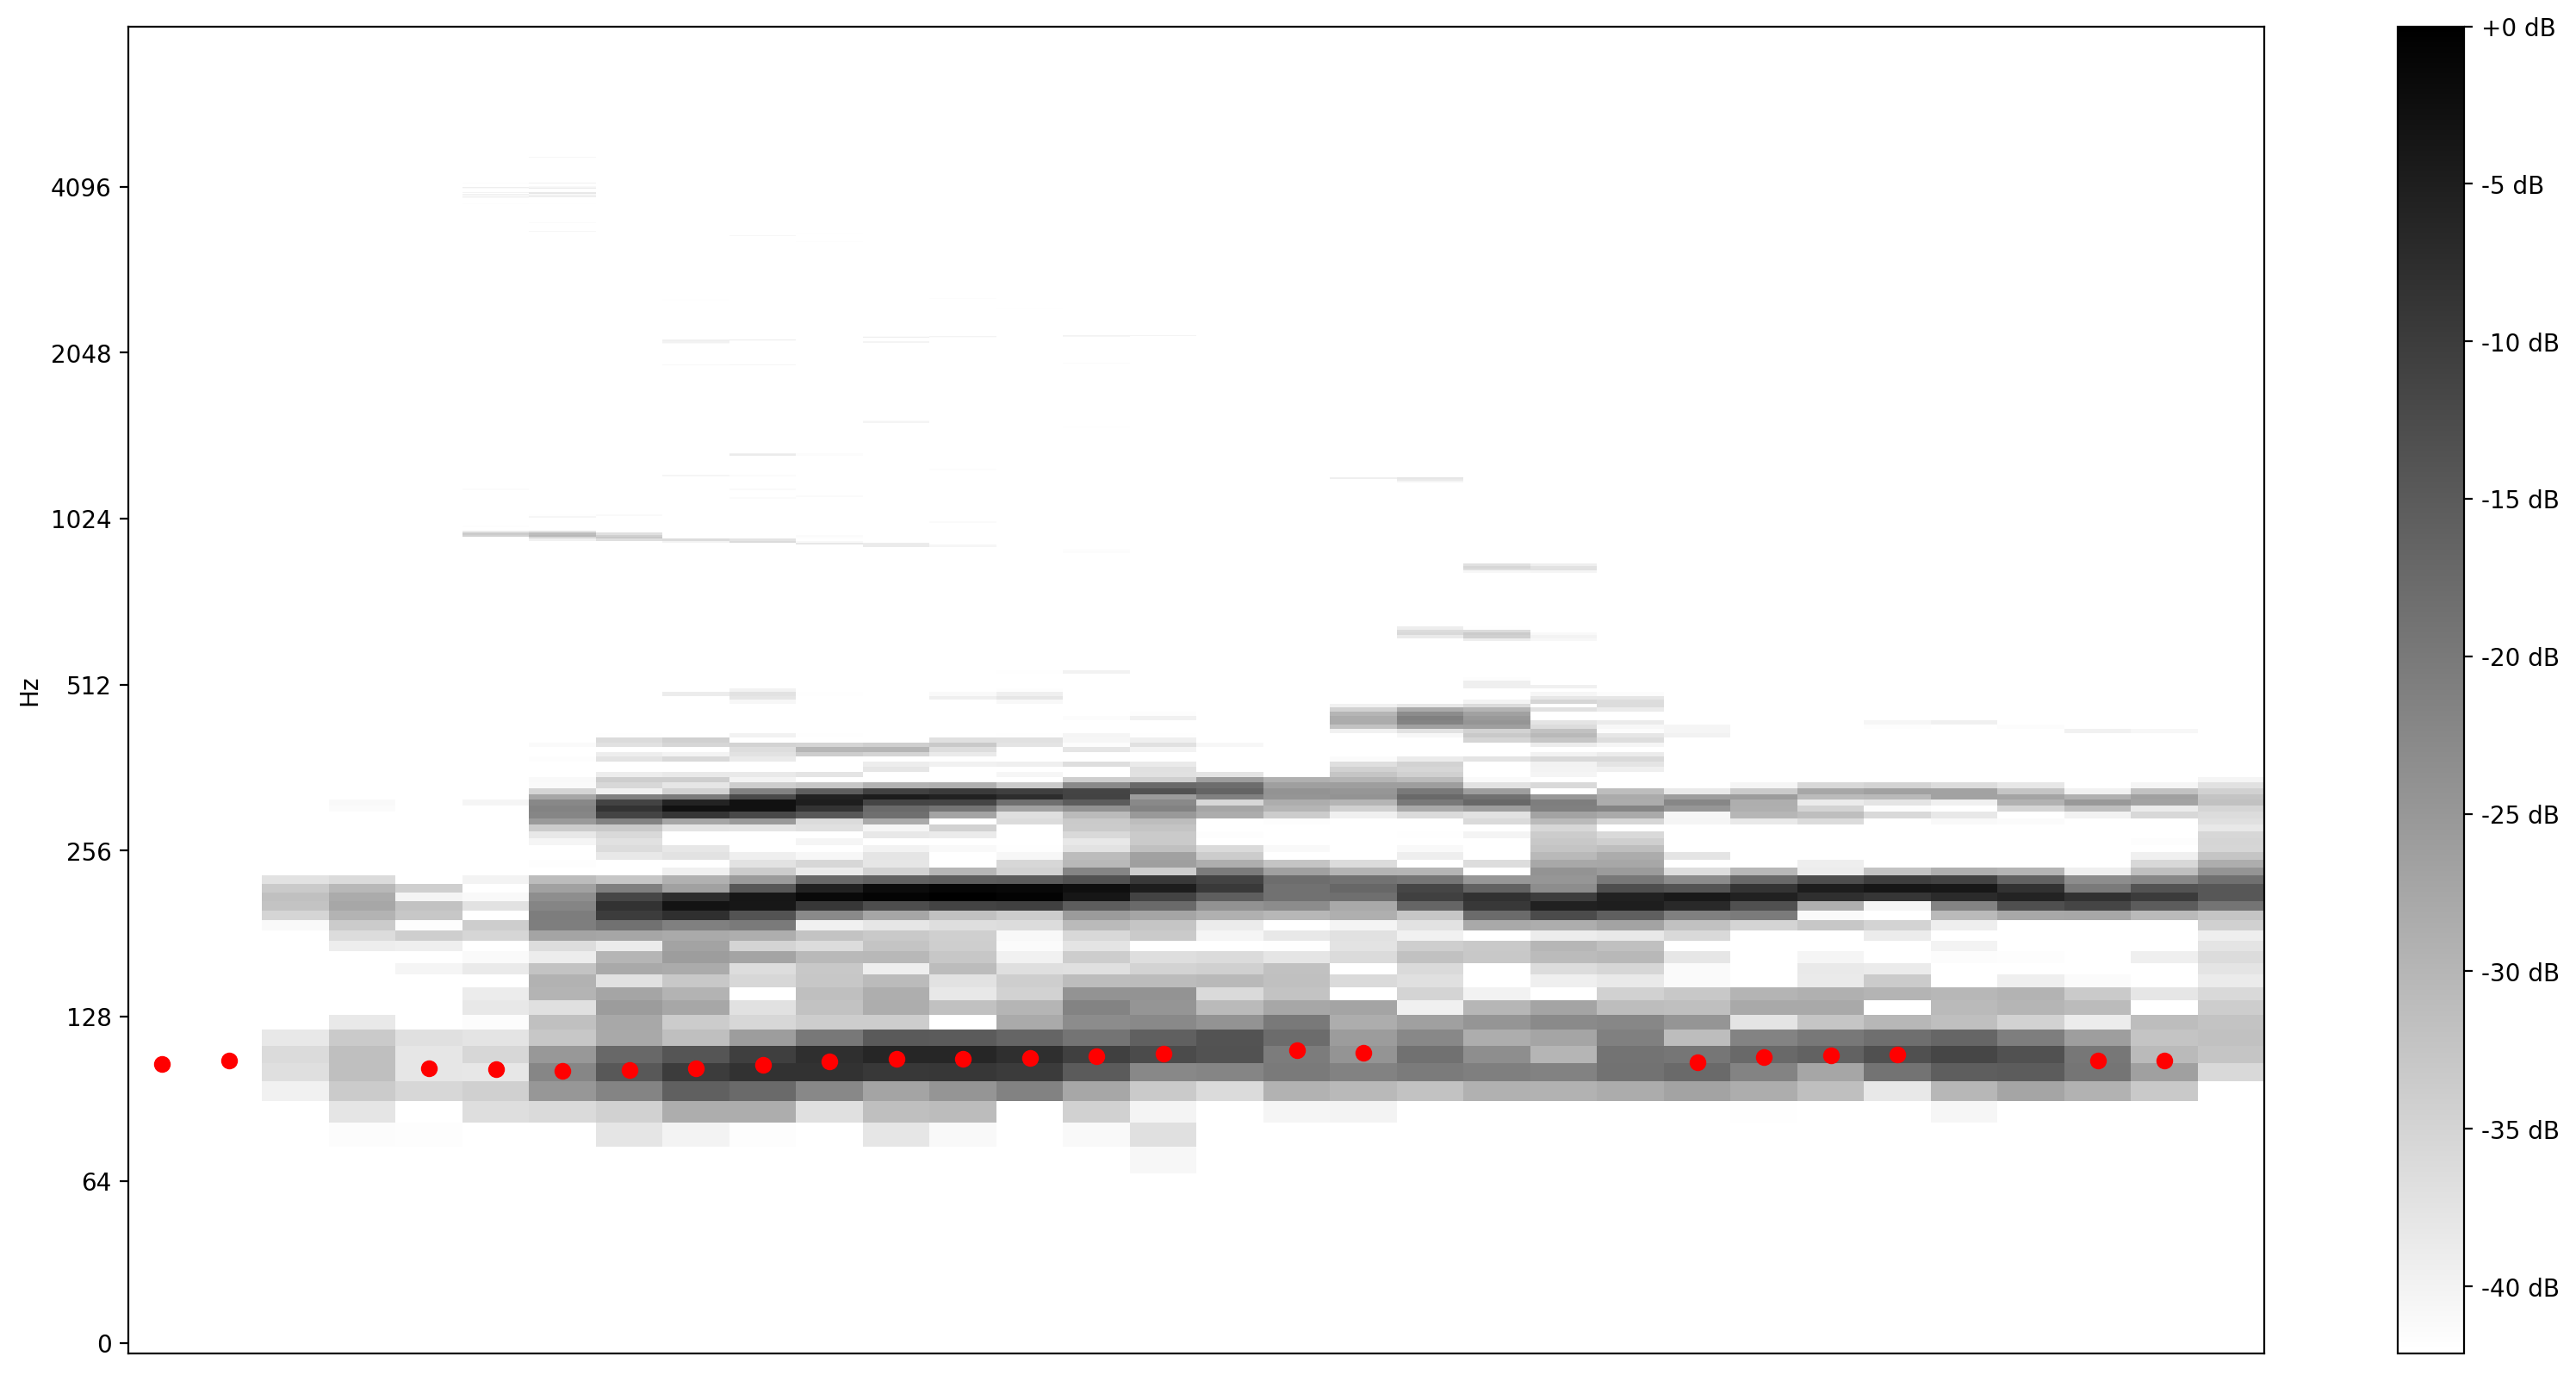

In [19]:
plot_stft(audio_samples / MAX_ABS_INT16 ,
          sample_rate=EXPECTED_SAMPLE_RATE, show_black_and_white=True)
# Note: conveniently, since the plot is in log scale, the pitch outputs
# also get converted to the log scale automatically by matplotlib.
plt.scatter(confident_pitch_outputs_x, confident_pitch_values_hz, c="r")

plt.show()

In [20]:
pitch_outputs_and_rests = [
    output2hz(p) if c >= 0.9 else 0
    for i, p, c in zip(indices, pitch_outputs, confidence_outputs)
]

In [21]:
A4 = 440
C0 = A4 * pow(2, -4.75)
note_names = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

def hz2offset(freq):
  # This measures the quantization error for a single note.
  if freq == 0:  # Rests always have zero error.
    return None
  # Quantized note.
  h = round(12 * math.log2(freq / C0))
  return 12 * math.log2(freq / C0) - h


# The ideal offset is the mean quantization error for all the notes
# (excluding rests):
offsets = [hz2offset(p) for p in pitch_outputs_and_rests if p != 0]
print("offsets: ", offsets)

ideal_offset = statistics.mean(offsets)
print("ideal offset: ", ideal_offset)

offsets:  [0.2043711511915518, 0.4493210958069085, -0.1507891638452321, -0.20471112041418849, -0.29462239994352046, -0.24717295779531412, -0.15123557655755704, 0.10919314147288617, 0.40075233252103715, -0.4522735655183041, -0.41126468403881233, -0.36641289396826693, -0.24218986346070892, -0.040187641220740034, 0.17111312286311886, -0.033529983001400865, 0.3201189188783857, -0.3236813293272647, -0.16537304355447446, -0.13061863912884775, 0.42811226279790304, 0.43124936939533143]
ideal offset:  -0.031810521220341344


In [22]:
def quantize_predictions(group, ideal_offset):
  # Group values are either 0, or a pitch in Hz.
  non_zero_values = [v for v in group if v != 0]
  zero_values_count = len(group) - len(non_zero_values)

  # Create a rest if 80% is silent, otherwise create a note.
  if zero_values_count > 0.8 * len(group):
    # Interpret as a rest. Count each dropped note as an error, weighted a bit
    # worse than a badly sung note (which would 'cost' 0.5).
    return 0.51 * len(non_zero_values), "Rest"
  else:
    # Interpret as note, estimating as mean of non-rest predictions.
    h = round(
        statistics.mean([
            12 * math.log2(freq / C0) - ideal_offset for freq in non_zero_values
        ]))
    octave = h // 12
    n = h % 12
    note = note_names[n] + str(octave)
    # Quantization error is the total difference from the quantized note.
    error = sum([
        abs(12 * math.log2(freq / C0) - ideal_offset - h)
        for freq in non_zero_values
    ])
    return error, note


def get_quantization_and_error(pitch_outputs_and_rests, predictions_per_eighth,
                               prediction_start_offset, ideal_offset):
  # Apply the start offset - we can just add the offset as rests.
  pitch_outputs_and_rests = [0] * prediction_start_offset + \
                            pitch_outputs_and_rests
  # Collect the predictions for each note (or rest).
  groups = [
      pitch_outputs_and_rests[i:i + predictions_per_eighth]
      for i in range(0, len(pitch_outputs_and_rests), predictions_per_eighth)
  ]

  quantization_error = 0

  notes_and_rests = []
  for group in groups:
    error, note_or_rest = quantize_predictions(group, ideal_offset)
    quantization_error += error
    notes_and_rests.append(note_or_rest)

  return quantization_error, notes_and_rests


best_error = float("inf")
best_notes_and_rests = None
best_predictions_per_note = None

for predictions_per_note in range(20, 65, 1):
  for prediction_start_offset in range(predictions_per_note):

    error, notes_and_rests = get_quantization_and_error(
        pitch_outputs_and_rests, predictions_per_note,
        prediction_start_offset, ideal_offset)

    if error < best_error:
      best_error = error
      best_notes_and_rests = notes_and_rests
      best_predictions_per_note = predictions_per_note

# At this point, best_notes_and_rests contains the best quantization.
# Since we don't need to have rests at the beginning, let's remove these:
while best_notes_and_rests[0] == 'Rest':
  best_notes_and_rests = best_notes_and_rests[1:]
# Also remove silence at the end.
while best_notes_and_rests[-1] == 'Rest':
  best_notes_and_rests = best_notes_and_rests[:-1]

In [23]:
# Creating the sheet music score.
sc = music21.stream.Score()
# Adjust the speed to match the actual singing.
bpm = 60 * 60 / best_predictions_per_note
print ('bpm: ', bpm)
a = music21.tempo.MetronomeMark(number=bpm)
sc.insert(0,a)

for snote in best_notes_and_rests:
    d = 'half'
    if snote == 'Rest':
      sc.append(music21.note.Rest(type=d))
    else:
      sc.append(music21.note.Note(snote, type=d))

bpm:  180.0


In [24]:
from IPython.core.display import display, HTML, Javascript
import json, random

def showScore(score):
    xml = open(score.write('musicxml')).read()
    showMusicXML(xml)

def showMusicXML(xml):
    DIV_ID = "OSMD_div"
    display(HTML('<div id="'+DIV_ID+'">loading OpenSheetMusicDisplay</div>'))
    script = """
    var div_id = %%DIV_ID%%;
    function loadOSMD() {
        return new Promise(function(resolve, reject){
            if (window.opensheetmusicdisplay) {
                return resolve(window.opensheetmusicdisplay)
            }
            // OSMD script has a 'define' call which conflicts with requirejs
            var _define = window.define // save the define object
            window.define = undefined // now the loaded script will ignore requirejs
            var s = document.createElement( 'script' );
            s.setAttribute( 'src', "https://cdn.jsdelivr.net/npm/opensheetmusicdisplay@0.7.6/build/opensheetmusicdisplay.min.js" );
            //s.setAttribute( 'src', "/custom/opensheetmusicdisplay.js" );
            s.onload=function(){
                window.define = _define
                resolve(opensheetmusicdisplay);
            };
            document.body.appendChild( s ); // browser will try to load the new script tag
        })
    }
    loadOSMD().then((OSMD)=>{
        window.openSheetMusicDisplay = new OSMD.OpenSheetMusicDisplay(div_id, {
          drawingParameters: "compacttight"
        });
        openSheetMusicDisplay
            .load(%%data%%)
            .then(
              function() {
                openSheetMusicDisplay.render();
              }
            );
    })
    """.replace('%%DIV_ID%%',DIV_ID).replace('%%data%%',json.dumps(xml))
    display(Javascript(script))
    return

In [25]:
# rendering the music score
showScore(sc)
print(best_notes_and_rests)

/usr/local/lib/python3.10/dist-packages/music21/musicxml/m21ToXml.py:510: MusicXMLWarning: <music21.stream.Score 0x7fd511b68a00> is not well-formed; see isWellFormedNotation()
  warnings.warn(f'{scOut} is not well-formed; see isWellFormedNotation()',


<IPython.core.display.Javascript object>

['G#2', 'A2']


In [26]:
# Saving the recognized musical notes as a MIDI file
converted_audio_file_as_midi = converted_audio_file[:-4] + '.mid'
fp = sc.write('midi', fp=converted_audio_file_as_midi)

In [27]:
wav_from_created_midi = converted_audio_file_as_midi.replace(' ', '_') + "_midioutput.wav"
print(wav_from_created_midi)

converted_audio_file.mid_midioutput.wav


In [35]:
!timidity --version

TiMidity++ version 2.14.0

Copyright (C) 1999-2004 Masanao Izumo <iz@onicos.co.jp>
Copyright (C) 1995 Tuukka Toivonen <tt@cgs.fi>

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.


In [36]:
!timidity converted_audio_file_as_midi -Ow -o $wav_from_created_midi

Playing converted_audio_file_as_midi
MIDI file: converted_audio_file_as_midi
converted_audio_file_as_midi: No such file or directory


In [37]:
Audio(wav_from_created_midi)